In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from evaluate import get_results
from omegaconf import OmegaConf
from main import load_data, make_model
from model import AEDist
import numpy as np
import os
import glob
import demap
from tqdm import tqdm
# from evaluation import compute_encoding_metrics, get_dataset_contents, get_noiseless_name, get_ambient_name, get_data_config, eval_results, compute_recon_metric
from evaluation import compute_all_metrics, get_noiseless_name, get_ambient_name
from transformations import NonTransform
import torch
import demap


In [2]:
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
run_id = 'tnzpgqqa'


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [3]:
run = api.run(f'{entity}/{project}/{run_id}')

In [4]:
cfg = OmegaConf.create(run.config)
folder_path = "../src/wandb/"
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
data_path = os.path.join(cfg.data.root, cfg.data.name + cfg.data.filetype)
data = np.load(data_path, allow_pickle=True)
model = AEDist.load_from_checkpoint(ckpt_path)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'activation_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_fn'])`.
  rank_zero_warn(


In [5]:
x_tensor = torch.tensor(data['data'][~data['is_train'].astype(bool)], dtype=torch.float32, device=model.device)
colors = data['colors'][~data['is_train'].astype(bool)]
x_true = data['data_gt'][~data['is_train'].astype(bool)]

In [6]:
x_tensor

tensor([[ 0.7675,  0.1583, -1.7146],
        [ 1.1745,  0.3066,  1.0330],
        [ 0.1543,  1.8832,  2.0958],
        ...,
        [-0.3436,  3.6854,  1.7753],
        [ 0.6520,  3.7341, -0.0361],
        [ 0.9770,  5.3826, -0.5004]])

In [7]:
with torch.no_grad():
    z = model.encode(x_tensor)
    xh = model.decode(z)

In [8]:
demap_val = demap.DEMaP(x_true, xh.cpu().numpy())

Text(0.5, 0.98, 'DEMaP=0.862')

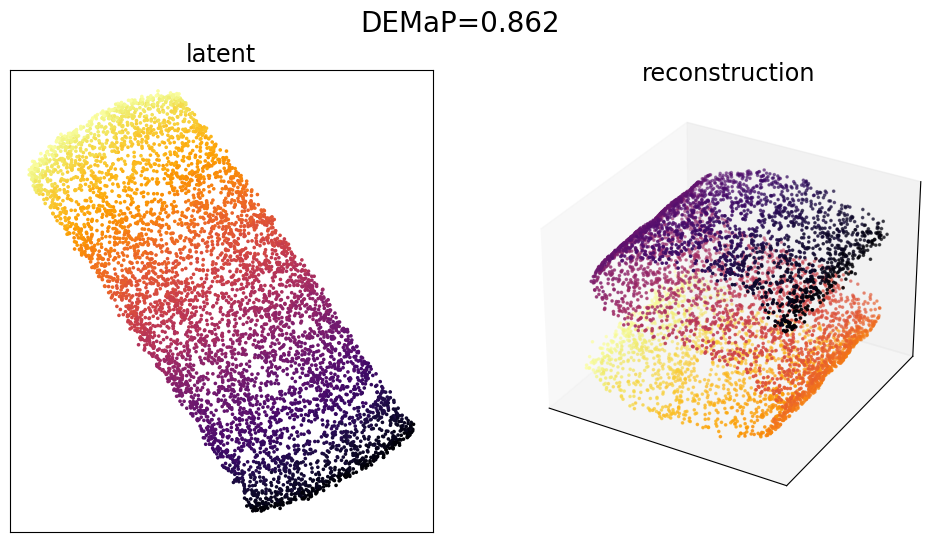

In [9]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
scprep.plot.scatter2d(z.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax1, title='latent')
ax2 = fig.add_subplot(122, projection='3d')
scprep.plot.scatter3d(xh.cpu().numpy(), c=colors, ticks=False, legend=False, ax=ax2, title='reconstruction')
plt.suptitle(f'DEMaP={np.round(demap_val, 3)}', fontsize=20)